In [21]:
import pandas as pd
import numpy as np
import h5py
import torch
import torch.nn as nn
import random
import os
import sys

#trying to ensure reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [22]:
# Setting path to load util functions
from pathlib import Path
parent_dir = Path.cwd().parents[1]
sys.path.append(os.path.abspath(parent_dir))

In [ ]:
#Loading data
with h5py.File('../../data/3d_array/mod_train_data_3d_h5.h5', 'r') as f:
    train_X = f['train_data_3d'][:]
with h5py.File('../../data/3d_array/mod_val_data_3d_h5.h5', 'r') as f:
    val_X = f['val_data_3d'][:]
with h5py.File('../../data/3d_array/test_data_3d_h5.h5', 'r') as f:
    test_X = f['test_data_3d'][:]

# train_y = pd.read_parquet('../../data/3d_array/train_targets.parquet')
# val_y = pd.read_parquet('../../data/3d_array/val_targets.parquet')

In [3]:
train_X.shape, val_X.shape

((289115, 13, 86), (32124, 13, 86))

In [4]:
np.isnan(train_X).any()

True

In [ ]:
train_X = np.nan_to_num(train_X, nan=0.0)
val_X = np.nan_to_num(val_X, nan=0.0)
test_X = np.nan_to_num(test_X, nan=0.0)

In [6]:
np.isnan(train_X).any()

False

In [ ]:
train_y = pd.read_parquet('../../data/3d_array/train_targets.parquet')
val_y = pd.read_parquet('../../data/3d_array/val_targets.parquet')
test_y = pd.read_parquet('../../data/3d_array/test_targets.parquet')

In [8]:
train_y.head()

,customer_ID,end_of_month,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-31,0
1,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-31,0
2,000084e5023181993c2e1b665ac88dbb1ce9ef621ec537...,2018-03-31,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2018-03-31,0
4,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2018-03-31,1


In [9]:
train_y['end_of_month'].value_counts()

end_of_month
2018-03-31    289115
Name: count, dtype: int64

In [10]:
train_y = train_y[train_y['end_of_month'].isin(['2018-03-31'])]
val_y = val_y[val_y['end_of_month'].isin(['2018-03-31'])]

C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_12164\639591509.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  train_y = train_y[train_y['end_of_month'].isin(['2018-03-31'])]
C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_12164\639591509.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  val_y = val_y[val_y['end_of_month'].isin(['2018-03-31'])]


In [11]:
train_y.sort_values(by=['customer_ID'])

,customer_ID,end_of_month,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-31,0
1,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-31,0
2,000084e5023181993c2e1b665ac88dbb1ce9ef621ec537...,2018-03-31,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2018-03-31,0
4,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2018-03-31,1
...,...,...,...
289110,fffe3ec7cdbc1caac845c884b389ed347bfc1da9d09731...,2018-03-31,1
289111,fffef3305f19a11fb6c15f4ebe9be1bd664540e57c0a6a...,2018-03-31,0
289112,ffff39cc22a375d07369980d02d617883dd28ad81a6aa3...,2018-03-31,0
289113,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,2018-03-31,0


In [12]:
train_X.shape, train_y.shape

((289115, 13, 86), (289115, 3))

In [13]:
val_X.shape, val_y.shape

((32124, 13, 86), (32124, 3))

In [14]:
class SmallRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, fc_size, output_size=1):
        super(SmallRNNModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, fc_size)
        self.output = nn.Linear(fc_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        # Take the output of the last time step
        lstm_last_out = lstm_out[:, -1, :]
        # Fully connected layer
        fc_out = self.fc(lstm_last_out)
        # Final output layer
        output = self.output(fc_out)
        # Apply sigmoid for binary classification
        return self.sigmoid(output)

# Example usage
input_size = train_X.shape[2]  # Number of features
hidden_size = 64  # Hidden state size for LSTM
fc_size = 32  # Size of the fully connected layer

model = SmallRNNModel(input_size=input_size, hidden_size=hidden_size, fc_size=fc_size)

In [15]:
batch_size = 10000
from torchinfo import summary
summary(model, input_size=(batch_size, train_X.shape[1], train_X.shape[2]), device='cpu',
        col_names=["input_size", "kernel_size","output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Kernel Shape              Output Shape              Param #
SmallRNNModel                            [10000, 13, 86]           --                        [10000, 1]                --
├─LSTM: 1-1                              [10000, 13, 86]           --                        [10000, 13, 64]           38,912
├─Linear: 1-2                            [10000, 64]               --                        [10000, 32]               2,080
├─Linear: 1-3                            [10000, 32]               --                        [10000, 1]                33
├─Sigmoid: 1-4                           [10000, 1]                --                        [10000, 1]                --
Total params: 41,025
Trainable params: 41,025
Non-trainable params: 0
Total mult-adds (G): 5.08
Input size (MB): 44.72
Forward/backward pass size (MB): 69.20
Params size (MB): 0.16
Estimated Total Size (MB): 114.08

In [16]:
from torch.utils.data import Dataset, DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        """
        Args:
            data: numpy array of shape (num_ids, time_steps, features)
            targets: numpy array of shape (num_ids,)
        """
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets).unsqueeze(1)  # Add dimension for output
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [17]:
train_dataset = TimeSeriesDataset(train_X, train_y['target'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [18]:
val_dataset = TimeSeriesDataset(val_X, val_y['target'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
test_dataset = TimeSeriesDataset(test_X, test_y['target'].values)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
train_dataset.__getitem__(0)[0].shape, train_dataset.__getitem__(0)[1]

(torch.Size([13, 86]), tensor([0.]))

In [20]:
val_dataset.__getitem__(0)[0].shape, val_dataset.__getitem__(0)[1]

(torch.Size([13, 86]), tensor([1.]))

In [23]:
from sklearn.metrics import roc_auc_score
import time
import copy

import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 20
patience = 3  # Number of epochs to wait for improvement before early stopping

# Initialize variables for early stopping
best_val_loss = float('inf')
best_val_auc = 0.0
best_model_wts = copy.deepcopy(model.parameters)
no_improve_epochs = 0

# For tracking metrics
train_losses = []
val_losses = []
val_aucs = []

# Move model to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Training on {device}")
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            
            # Collect predictions and labels for AUC calculation
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    epoch_val_loss = running_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)
    
    all_preds = [p[0] for p in all_preds]  # Flatten predictions
    all_labels = [l[0] for l in all_labels]  # Flatten labels
    epoch_val_auc = roc_auc_score(all_labels, all_preds)
    val_aucs.append(epoch_val_auc)
    
    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val AUC: {epoch_val_auc:.4f}")
    
    # Check if this is the best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_val_auc = epoch_val_auc
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
    
    # Early stopping
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# Training complete
time_elapsed = time.time() - start_time
print(f"Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
print(f"Best val loss: {best_val_loss:.4f}, Best val AUC: {best_val_auc:.4f}")

# Load best model weights
model.load_state_dict(best_model_wts)

Training on cuda:0
Epoch 1/20 - Train Loss: 0.4898, Val Loss: 0.3256, Val AUC: 0.9174
Epoch 2/20 - Train Loss: 0.3019, Val Loss: 0.2791, Val AUC: 0.9370
Epoch 3/20 - Train Loss: 0.2713, Val Loss: 0.2612, Val AUC: 0.9439
Epoch 4/20 - Train Loss: 0.2607, Val Loss: 0.2544, Val AUC: 0.9468
Epoch 5/20 - Train Loss: 0.2556, Val Loss: 0.2516, Val AUC: 0.9484
Epoch 6/20 - Train Loss: 0.2524, Val Loss: 0.2484, Val AUC: 0.9493
Epoch 7/20 - Train Loss: 0.2500, Val Loss: 0.2468, Val AUC: 0.9499
Epoch 8/20 - Train Loss: 0.2484, Val Loss: 0.2459, Val AUC: 0.9503
Epoch 9/20 - Train Loss: 0.2470, Val Loss: 0.2449, Val AUC: 0.9507
Epoch 10/20 - Train Loss: 0.2459, Val Loss: 0.2444, Val AUC: 0.9510
Epoch 11/20 - Train Loss: 0.2454, Val Loss: 0.2437, Val AUC: 0.9513
Epoch 12/20 - Train Loss: 0.2447, Val Loss: 0.2440, Val AUC: 0.9515
Epoch 13/20 - Train Loss: 0.2436, Val Loss: 0.2430, Val AUC: 0.9515
Epoch 14/20 - Train Loss: 0.2428, Val Loss: 0.2428, Val AUC: 0.9517
Epoch 15/20 - Train Loss: 0.2424, Val 

<All keys matched successfully>

In [26]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize a list to store predictions
val_predictions = []

# Disable gradient computation for inference
with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        val_predictions.extend(outputs.cpu().numpy())

# Flatten the predictions
val_predictions = [p[0] for p in val_predictions]
print("Validation predictions obtained.")

Validation predictions obtained.


In [34]:
from utils.threshold import find_threshold_binary_search
threshold = find_threshold_binary_search(y_true=np.array(all_labels).astype('int'), y_pred_proba=np.array(val_predictions), target_class=0)[0]

Target Recall: >= 0.9800 for Class 0
Threshold found by Binary Search: 0.7709389
Achieved Recall at Threshold: 0.9800


In [35]:
threshold

0.7709389328956604

In [37]:
from sklearn.metrics import classification_report

# Convert predictions to binary (threshold = 0.5)
binary_preds = [1 if p >= threshold else 0 for p in val_predictions]

# Generate classification report
report = classification_report(all_labels, binary_preds, target_names=['Class 0', 'Class 1'], digits = 4)
print(report)

              precision    recall  f1-score   support

     Class 0     0.8589    0.9800    0.9154     23806
     Class 1     0.9040    0.5391    0.6754      8318

    accuracy                         0.8658     32124
   macro avg     0.8814    0.7595    0.7954     32124
weighted avg     0.8706    0.8658    0.8533     32124



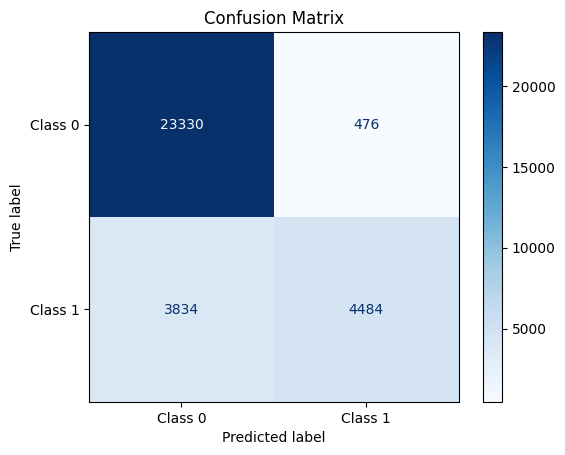

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(all_labels, binary_preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def evaluate_model_for_recall(target_class, desired_recall, y_true, y_pred_proba):
    """
    Evaluate the model by finding the threshold for a specified recall of a target class,
    and then print the classification report and confusion matrix.
    Args:
        target_class (int): The class for which the recall is specified (0 or 1).
        desired_recall (float): The desired recall value (between 0 and 1).
        y_true (list or np.array): Ground truth labels.
        y_pred_proba (list or np.array): Predicted probabilities for the positive class.

    Returns:
        float: The threshold value that achieves the desired recall.
    """
    # Sort predictions and true labels by predicted probabilities
    threshold = find_threshold_binary_search(y_true=y_true, y_pred_proba=y_pred_proba, target_class=target_class, target_recall=desired_recall)[0]

    # Convert probabilities to binary predictions using the threshold
    binary_preds = [1 if p >= threshold else 0 for p in y_pred_proba]

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, binary_preds, target_names=['Class 0', 'Class 1'], digits=4))

    # Compute and display confusion matrix
    cm = confusion_matrix(y_true, binary_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    return threshold

Target Recall: >= 0.9800 for Class 0
Threshold found by Binary Search: 0.7709389
Achieved Recall at Threshold: 0.9800
Classification Report:
              precision    recall  f1-score   support

     Class 0     0.8589    0.9800    0.9154     23806
     Class 1     0.9040    0.5391    0.6754      8318

    accuracy                         0.8658     32124
   macro avg     0.8814    0.7595    0.7954     32124
weighted avg     0.8706    0.8658    0.8533     32124



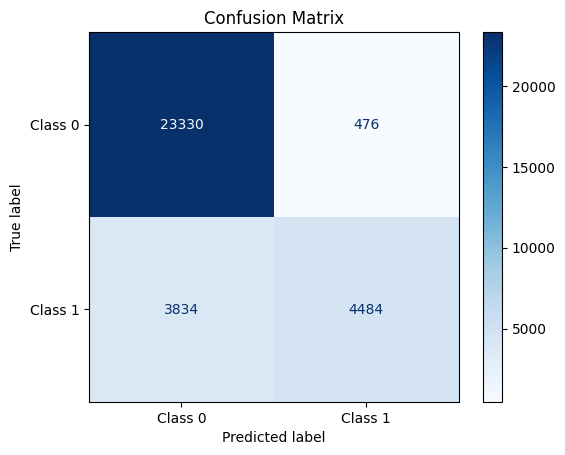

0.7709389328956604

In [45]:
evaluate_model_for_recall(target_class=0, desired_recall=0.98, y_true=np.array(all_labels).astype('int'), y_pred_proba=np.array(val_predictions))

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Set model to evaluation mode
model.eval()

# Check if CUDA is available and move model to the appropriate device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Lists to store predictions and true values
all_preds = []
all_labels = []

# Perform inference without gradient calculation
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Store predictions and labels
        all_preds.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all batches
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Convert predictions to binary (0 or 1) using threshold of 0.5
pred_classes = (all_preds > 0.5).astype(int)
true_classes = all_labels.astype(int)

# Generate classification report

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, pred_classes, digits = 4))

# Calculate and print accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print ROC-AUC score
auc = roc_auc_score(true_classes, all_preds)
print(f"ROC-AUC Score: {auc:.4f}")

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(true_classes, pred_classes))

In [ ]:
evaluate_model_for_recall(target_class=0, desired_recall=0.98, y_true=true_classes, y_pred_proba=all_preds)

In [22]:
import os

# Save the model weights

# Create directory if it doesn't exist
save_dir = '../../models/deep_learning'
os.makedirs(save_dir, exist_ok=True)

# Save model state dictionary
model_path = os.path.join(save_dir, 'experiment_1.pth')
torch.save(model.state_dict(), model_path)

# Save additional information for later reference
checkpoint_path = os.path.join(save_dir, 'experiment_1.pth')
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_loss': best_val_loss,
    'val_auc': best_val_auc,
    'input_size': input_size,
    'hidden_size': hidden_size,
    'fc_size': fc_size,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_aucs': val_aucs
}
torch.save(checkpoint, checkpoint_path)

print(f"Model saved to {model_path}")
print(f"Checkpoint saved to {checkpoint_path}")

Model saved to ../../models/deep_learning\experiment_1.pth
Checkpoint saved to ../../models/deep_learning\experiment_1.pth
